##**FaceMask Detection Using Deep Learning & CV**🕵️

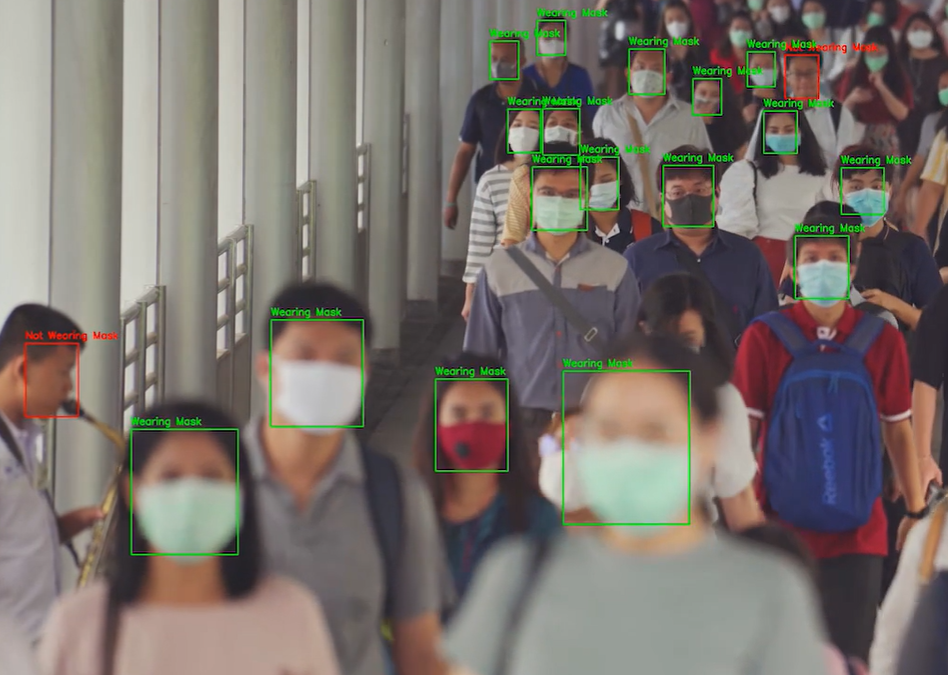

####**Scope & Objective:** 

             The main scope of  this project is to find the person who not wearing the mask. We have to aware the person about the spread of OMICRON, wearing masks is important. Protective masks are said to lower the chances of omicron virus entering our respiratory system through droplets that are present in the air. Wearing of masks is especially recommended for people living in densely populated areas. Its reduce the spread of the Virus.

####**Business Problem Statement:**

               This Project is helps to understand the importance of wearing mask. We Built a model with some important libraries. We have tested the model for different conditions. First we feed the dataset in the model, run the training program, which trains the model on the given dataset. Then we run the detection model for detecting the person is wearing facemask or not. 


**Libraries**

In [ ]:
# Basic Libraries
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
import cv2
from scipy.spatial import distance
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Using haar cascade to detect faces**

  Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image

In [ ]:
#loading haarcascade_frontalface_default.xml
face_detect_model = cv2.CascadeClassifier('/content/drive/MyDrive/Capstone-2 dataset /Haarcascades/haarcascade_frontalface_default.xml')

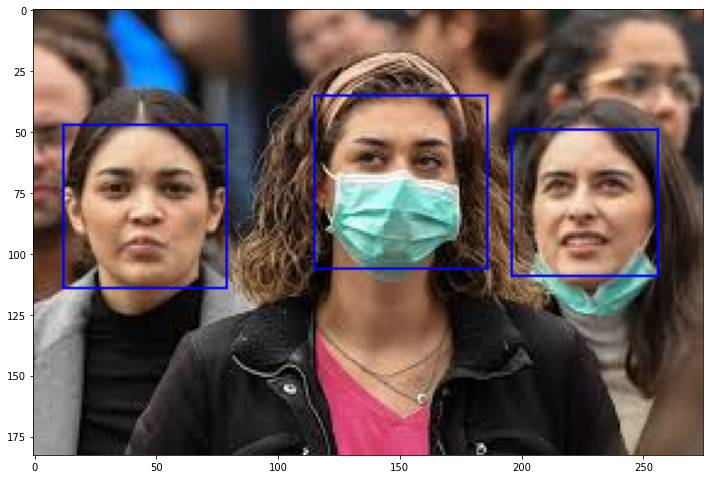

In [ ]:
#trying it out on a sample image
img = cv2.imread('/content/drive/MyDrive/Capstone-2 dataset /images.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_detect_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

output = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(output)

**Load the dataset**

In [ ]:
arr = []
data= "/content/drive/MyDrive/Capstone-2 dataset /Face Mask Dataset/"
train="/content/drive/MyDrive/Capstone-2 dataset /Face Mask Dataset/Train"
test='/content/drive/MyDrive/Capstone-2 dataset /Face Mask Dataset/Test'
valid='/content/drive/MyDrive/Capstone-2 dataset /Face Mask Dataset/Validation'

for strat in os.listdir(data):
    for label in os.listdir(data+"/"+strat):
        for image in glob.glob(data+strat+"/"+label+"/"+"*.png"):
            arr.append({"path": image, "label": label, "strat": strat})
 
 
mydata= pd.DataFrame(arr).sample(frac=1, random_state=73)
mydata

,path,label,strat
11179,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Test
1100,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
4758,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
10843,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Test
3223,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
...,...,...,...
4419,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
8586,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithMask,Train
4014,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
8338,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithMask,Train


**Basic Check**

In [ ]:
mydata.shape

(11792, 3)

In [ ]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11792 entries, 11179 to 5014
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    11792 non-null  object
 1   label   11792 non-null  object
 2   strat   11792 non-null  object
dtypes: object(3)
memory usage: 368.5+ KB


In [ ]:
mydata.describe()

,path,label,strat
count,11792,11792,11792
unique,11792,2,3
top,/content/drive/MyDrive/Capstone-2 dataset /Fac...,WithoutMask,Train
freq,1,5909,10000


**Null Check**

In [ ]:
mydata.isnull().sum()

path     0
label    0
strat    0
dtype: int64

(11792, 3)


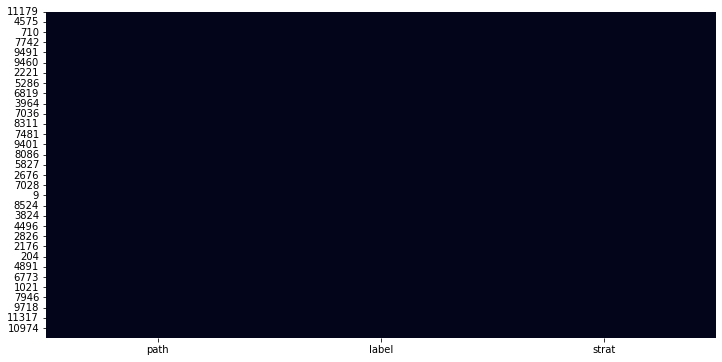

In [ ]:
print(mydata.shape)
plt.figure(figsize=(12,6))
sns.heatmap(mydata.isnull(), cbar=False)
plt.show()

In [ ]:
# We can check how many WithoutMask data & WithMask data in the dataset
((mydata["label"] == 'WithoutMask').sum(), (mydata["label"] == 'WithMask').sum())

(5909, 5883)

In [ ]:
# We can check how many Train data, Test data, Validation data in the dataset
((mydata["strat"] == 'Train').sum(), (mydata["strat"] == 'Test').sum(),(mydata["strat"] == 'Validation').sum())

(10000, 992, 800)

##**Data Visualization**

Data visualization is one of the steps of the data science process, which states that after data has been collected, processed and modeled, it must be visualized for conclusions to be made.

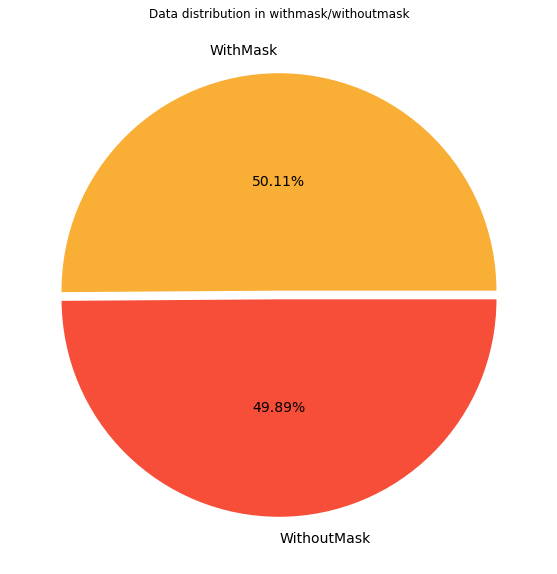

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
labels = ['WithMask', 'WithoutMask']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = mydata['label'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Data distribution in withmask/withoutmask')
plt.show()

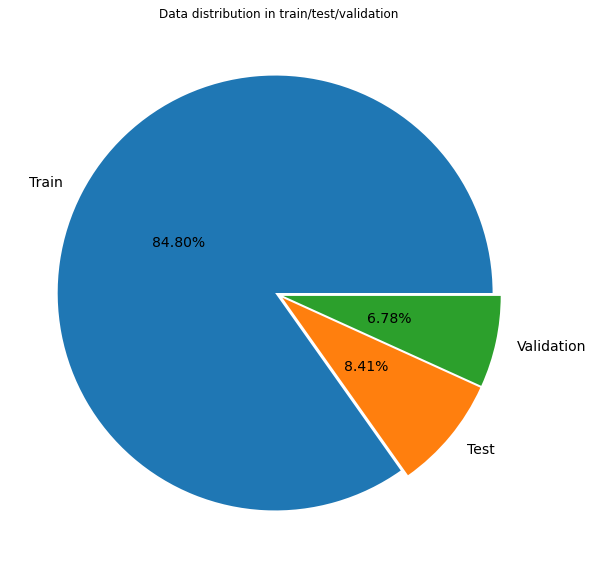

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Train', 'Test','Validation']
plt.pie(x = mydata['strat'].value_counts(), autopct='%.2f%%', explode=[0.02]*3, labels=labels, pctdistance=0.5, textprops={'fontsize': 14})
plt.title('Data distribution in train/test/validation')
plt.show()

**Data Augmentation(Preprocess):**

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.

In [ ]:
data_generator_train= ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

In [ ]:
train_generator = data_generator_train.flow_from_directory(directory=train,target_size=(128,128),class_mode='categorical',batch_size=32)

val_generator = data_generator_train.flow_from_directory(directory=valid,target_size=(128,128),class_mode='categorical',batch_size=32)

test_generator = data_generator_train.flow_from_directory(directory=test,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


**Testing the CV model on the test data**

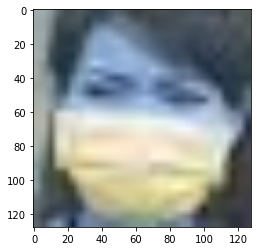

In [ ]:
sample_mask_img = cv2.imread('/content/drive/MyDrive/Capstone-2 dataset /Face Mask Dataset/Test/WithMask/1363.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

* This model is able to identify the person wearing the mask or not

**Building DenseNet201 model:**

DenseNet-201 is a convolutional neural network that is 201 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
base_model_densenet201 = tf.keras.applications.densenet.DenseNet201(weights='imagenet', input_shape = (128,128,3),include_top=False)

for layer in base_model_densenet201.layers:
    layer.trainable = False
    
model_densenet201 = Sequential()
model_densenet201.add(base_model_densenet201)
model_densenet201.add(Flatten())
model_densenet201.add(Dense(2,activation='sigmoid'))
model_densenet201.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_7 (Flatten)         (None, 30720)             0         
                                                                 
 dense_11 (Dense)            (None, 2)                 61442     
                                                                 
Total params: 18,383,426
Trainable params: 61,442
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
model_densenet201.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")


In [ ]:
model_densenet201_fit= model_densenet201.fit(train_generator, validation_data = val_generator,steps_per_epoch=len(train_generator)//32, epochs = 20)

Epoch 1/20
9/9 [==============================] - 96s 10s/step - loss: 0.0877 - accuracy: 0.9549 - val_loss: 0.0902 - val_accuracy: 0.9900
Epoch 2/20
9/9 [==============================] - 78s 9s/step - loss: 0.1304 - accuracy: 0.9861 - val_loss: 0.0788 - val_accuracy: 0.9925
Epoch 3/20
9/9 [==============================] - 78s 9s/step - loss: 0.2503 - accuracy: 0.9688 - val_loss: 0.0233 - val_accuracy: 0.9962
Epoch 4/20
9/9 [==============================] - 78s 9s/step - loss: 0.1684 - accuracy: 0.9792 - val_loss: 2.8793e-04 - val_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 78s 9s/step - loss: 0.1555 - accuracy: 0.9896 - val_loss: 0.0148 - val_accuracy: 0.9975
Epoch 6/20
9/9 [==============================] - 78s 9s/step - loss: 0.0162 - accuracy: 0.9896 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 7/20
9/9 [==============================] - 78s 9s/step - loss: 0.0529 - accuracy: 0.9896 - val_loss: 0.0021 - val_accuracy: 0.9987
Epoch 8/20
9/9 [=============

In [ ]:
model_densenet201.evaluate_generator(test_generator)

[0.05017915368080139, 0.9899193644523621]

* Our DenseNet201 model achieved 98% accuracy on test data

In [ ]:
model_densenet201_predict=model_densenet201.predict(sample_mask_img)
model_densenet201_predict

array([[9.9913037e-01, 6.5124035e-04]], dtype=float32)

#### Visualize Training and Validation curves for DenseNet201 Model

Text(0.5, 1.0, 'Accuracy Curves')

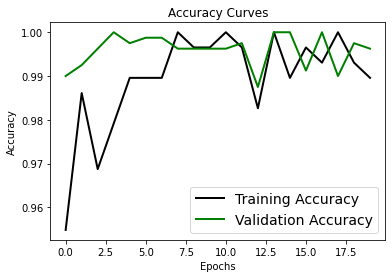

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_densenet201_fit.history['accuracy'], 'black', linewidth=2.0)
plt.plot(model_densenet201_fit.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Loss Curves')

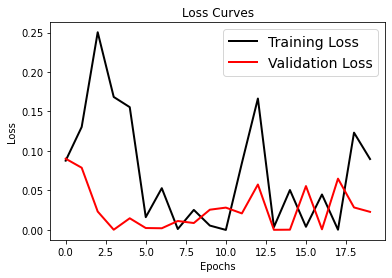

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_densenet201_fit.history['loss'], 'black', linewidth=2.0)
plt.plot(model_densenet201_fit.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

**Save the Model to disk**

In [ ]:
# serialize the model to disk
model_densenet201.save("facemask_detector_densenet201_model", save_format="h5")

**Building VGG19 model:**

VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
base_model_vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in base_model_vgg19.layers:
    layer.trainable = False
    
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(2,activation='sigmoid'))
model_vgg19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model_vgg19.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
model_vgg19_fit=model_vgg19.fit_generator(train_generator, validation_data = val_generator,steps_per_epoch=len(train_generator)//32, epochs = 20)

Epoch 1/20
9/9 [==============================] - 383s 46s/step - loss: 0.5814 - accuracy: 0.6632 - val_loss: 0.4445 - val_accuracy: 0.7625
Epoch 2/20
9/9 [==============================] - 248s 29s/step - loss: 0.2809 - accuracy: 0.8750 - val_loss: 0.2121 - val_accuracy: 0.9250
Epoch 3/20
9/9 [==============================] - 247s 29s/step - loss: 0.1825 - accuracy: 0.9306 - val_loss: 0.1668 - val_accuracy: 0.9325
Epoch 4/20
9/9 [==============================] - 241s 28s/step - loss: 0.1747 - accuracy: 0.9236 - val_loss: 0.1336 - val_accuracy: 0.9475
Epoch 5/20
9/9 [==============================] - 237s 28s/step - loss: 0.0964 - accuracy: 0.9688 - val_loss: 0.1201 - val_accuracy: 0.9575
Epoch 6/20
9/9 [==============================] - 236s 28s/step - loss: 0.1047 - accuracy: 0.9688 - val_loss: 0.1094 - val_accuracy: 0.9613
Epoch 7/20
9/9 [==============================] - 236s 28s/step - loss: 0.1137 - accuracy: 0.9618 - val_loss: 0.1052 - val_accuracy: 0.9600
Epoch 8/20
9/9 [====

In [ ]:
model_vgg19.evaluate_generator(test_generator)

[0.05182403698563576, 0.9828628897666931]

* Our VGG19 model achieved 98% accuracy on test data





In [ ]:
model_vgg19_predict=model_vgg19.predict(sample_mask_img)
model_vgg19_predict

array([[0.8532771 , 0.10869485]], dtype=float32)

#### Visualize Training and Validation curves for VGG19 Model

Text(0.5, 1.0, 'Accuracy Curves')

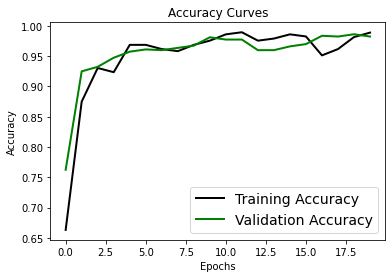

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_vgg19_fit.history['accuracy'], 'black', linewidth=2.0)
plt.plot(model_vgg19_fit.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Loss Curves')

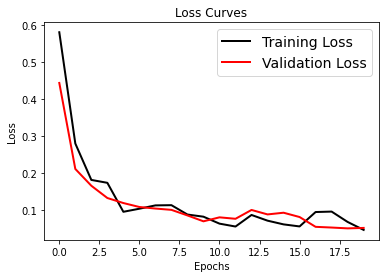

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_vgg19_fit.history['loss'], 'black', linewidth=2.0)
plt.plot(model_vgg19_fit.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

**Save the Model to disk**

In [ ]:
# serialize the model to disk
model_vgg19.save("facemask_detector_vgg19_model", save_format="h5")

**Building MobileNetV2 transfer learning model:**

MobileNet-v2 is a convolutional neural network that is 53 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
base_model_MobileNetV2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in base_model_MobileNetV2.layers:
    layer.trainable = False
    
model_MobileNetV2 = Sequential()
model_MobileNetV2.add(base_model_MobileNetV2)
model_MobileNetV2.add(Flatten())
model_MobileNetV2.add(Dense(2,activation='sigmoid'))
model_MobileNetV2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 20480)             0         
                                                                 
 dense_8 (Dense)             (None, 2)                 40962     
                                                                 
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model_MobileNetV2.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
model_MobileNetV2_fit=model_MobileNetV2.fit_generator(train_generator, validation_data = val_generator,steps_per_epoch=len(train_generator)//32, epochs = 20)

Epoch 1/20
9/9 [==============================] - 36s 3s/step - loss: 0.2920 - accuracy: 0.9062 - val_loss: 0.2160 - val_accuracy: 0.9550
Epoch 2/20
9/9 [==============================] - 26s 3s/step - loss: 0.1487 - accuracy: 0.9722 - val_loss: 0.0855 - val_accuracy: 0.9850
Epoch 3/20
9/9 [==============================] - 27s 3s/step - loss: 0.1418 - accuracy: 0.9757 - val_loss: 0.0623 - val_accuracy: 0.9862
Epoch 4/20
9/9 [==============================] - 23s 3s/step - loss: 0.0823 - accuracy: 0.9816 - val_loss: 0.0861 - val_accuracy: 0.9750
Epoch 5/20
9/9 [==============================] - 26s 3s/step - loss: 0.0400 - accuracy: 0.9861 - val_loss: 0.0830 - val_accuracy: 0.9837
Epoch 6/20
9/9 [==============================] - 27s 3s/step - loss: 0.0388 - accuracy: 0.9792 - val_loss: 0.0562 - val_accuracy: 0.9850
Epoch 7/20
9/9 [==============================] - 22s 3s/step - loss: 0.0292 - accuracy: 0.9861 - val_loss: 0.0808 - val_accuracy: 0.9862
Epoch 8/20
9/9 [==================

In [ ]:
model_MobileNetV2.evaluate_generator(test_generator)

[0.08873504400253296, 0.9879032373428345]

* Our MobileNetV2 model achieved 98% accuracy on test data





In [ ]:
model_MobileNetV2_predict=model_MobileNetV2.predict(sample_mask_img)
model_MobileNetV2_predict

array([[7.8588724e-04, 9.9555981e-01]], dtype=float32)

#### Visualize Training and Validation curves for MobileNetV2 Model

Text(0.5, 1.0, 'Accuracy Curves')

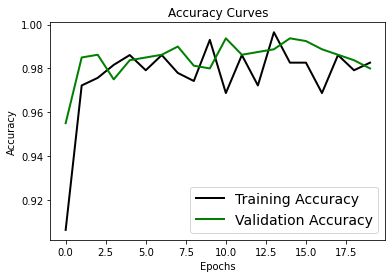

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_MobileNetV2_fit.history['accuracy'], 'black', linewidth=2.0)
plt.plot(model_MobileNetV2_fit.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Loss Curves')

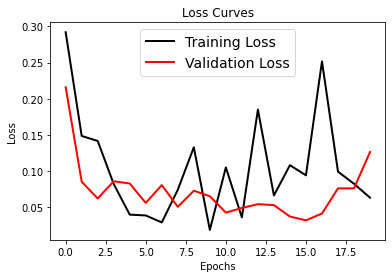

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_MobileNetV2_fit.history['loss'], 'black', linewidth=2.0)
plt.plot(model_MobileNetV2_fit.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

**Save the Model to disk**

In [ ]:
# serialize the model to disk
model_MobileNetV2.save("facemask_detector_MobileNetV2_model", save_format="h5")

**Building InceptionV3 model:**

Inception-v3 is a convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network.

In [ ]:
base_model_InceptionV3 = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(128,128,3))

for layer in base_model_InceptionV3.layers:
    layer.trainable = False
    
model_InceptionV3 = Sequential()
model_InceptionV3.add(base_model_InceptionV3)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(2,activation='sigmoid'))
model_InceptionV3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 2)                 16386     
                                                                 
Total params: 21,819,170
Trainable params: 16,386
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_InceptionV3.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
model_InceptionV3_fit=model_InceptionV3.fit_generator(train_generator, validation_data = val_generator,steps_per_epoch=len(train_generator)//32, epochs = 20)

Epoch 1/20
9/9 [==============================] - 40s 4s/step - loss: 0.8664 - accuracy: 0.8090 - val_loss: 0.4389 - val_accuracy: 0.8863
Epoch 2/20
9/9 [==============================] - 34s 4s/step - loss: 0.2277 - accuracy: 0.9549 - val_loss: 0.0633 - val_accuracy: 0.9762
Epoch 3/20
9/9 [==============================] - 34s 4s/step - loss: 0.0956 - accuracy: 0.9722 - val_loss: 0.0588 - val_accuracy: 0.9800
Epoch 4/20
9/9 [==============================] - 52s 6s/step - loss: 0.0714 - accuracy: 0.9757 - val_loss: 0.0549 - val_accuracy: 0.9850
Epoch 5/20
9/9 [==============================] - 35s 4s/step - loss: 0.1085 - accuracy: 0.9826 - val_loss: 0.0471 - val_accuracy: 0.9925
Epoch 6/20
9/9 [==============================] - 35s 4s/step - loss: 0.1398 - accuracy: 0.9722 - val_loss: 0.0690 - val_accuracy: 0.9850
Epoch 7/20
9/9 [==============================] - 50s 6s/step - loss: 0.2014 - accuracy: 0.9688 - val_loss: 0.0600 - val_accuracy: 0.9862
Epoch 8/20
9/9 [==================

In [ ]:
model_InceptionV3.evaluate_generator(test_generator)

[0.09466218948364258, 0.9868951439857483]

* Our InceptionV3 model achieved 98% accuracy on test data

In [ ]:
model_InceptionV3_predict=model_InceptionV3.predict(sample_mask_img)
model_InceptionV3_predict

array([[0.6228224 , 0.40249798]], dtype=float32)

#### Visualize Training and Validation curves for InceptionV3 Model

Text(0.5, 1.0, 'Accuracy Curves')

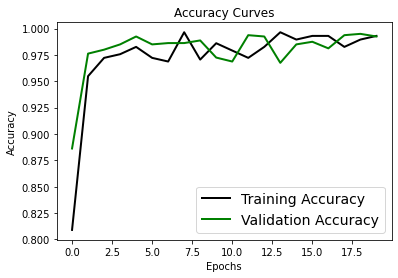

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_InceptionV3_fit.history['accuracy'], 'black', linewidth=2.0)
plt.plot(model_InceptionV3_fit.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Loss Curves')

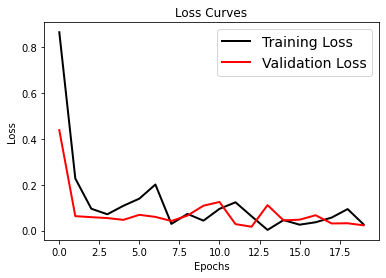

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(model_InceptionV3_fit.history['loss'], 'black', linewidth=2.0)
plt.plot(model_InceptionV3_fit.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

**Save the Model to Disk**

In [ ]:
# serialize the model to disk
model_InceptionV3.save("facemask_detector_InceptionV3_model", save_format="h5")

**Integrating with haar cascade:**


We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

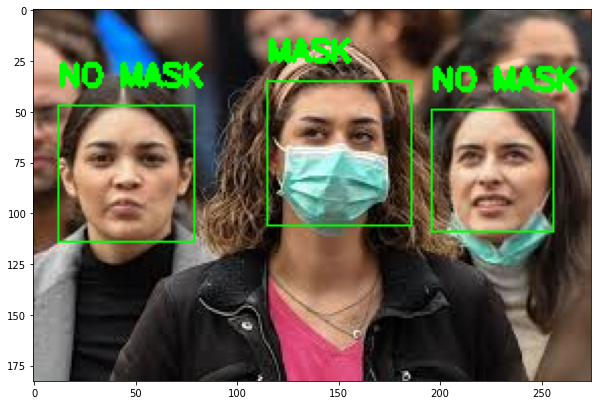

In [ ]:
MIN_DISTANCE = 0
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model_InceptionV3.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

* By Using the model_Inception its sucessfully detect the face.By using the same way we also use other three model to predict the person wearing the mask or not.

###**🏆Conclusion :**

* In this Project, we built a Multi models that could approximately Predict the person wearing mask or not by given some information about the population.
* Looking the above models that could give us a Model Accuracy are,

* By looking all the deep learning models gives us 98% Accurracy.
* By looking all the model error and accuracy rate graph its pretty good only.

#### So we say that all the deep learning models gives us the best accuracy. All the above models are Good to be Predicted the future data and upcoming data. we can use it......

--THANK YOU




